In [1]:
import numpy as np
import sklearn
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
data_pd = pd.read_csv('data/data_cut_1000.csv')

##### Предварительно обработаем таблицу: выкинем наны, вопросительные знаки и заменим неравенства, задающие классы на числа 0 и 1

In [3]:
data_pd = data_pd.dropna()
data_pd.info()

a = set()
for index, row in data_pd.iterrows():
    for item in row:
        if item == " ?":
            a.add(index)

data_pd.drop(list(a), axis=0, inplace=True)

data_pd['Money'] = (data_pd['Money'] == " <=50K").astype('int64')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 998
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             999 non-null    int64 
 1   Workclass       999 non-null    object
 2   Fnlwgt          999 non-null    int64 
 3   Education       999 non-null    object
 4   Education-num   999 non-null    int64 
 5   Marital-status  999 non-null    object
 6   Occupation      999 non-null    object
 7   Relationship    999 non-null    object
 8   Race            999 non-null    object
 9   Sex             999 non-null    object
 10  Capital-gain    999 non-null    int64 
 11  Capital-loss    999 non-null    int64 
 12  Hours-per-week  999 non-null    int64 
 13  Native-country  999 non-null    object
 14  Money           999 non-null    object
dtypes: int64(6), object(9)
memory usage: 124.9+ KB


In [4]:
X = data_pd.drop(['Money'], axis=1)
y = data_pd['Money']

##### Разобьем данные:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

##### Обучим кастомное дерево решений: 

In [6]:
from src.decision_tree import DecisionTree

my_ds = DecisionTree(max_depth=5, min_node_size=20)
root_train_pd = my_ds.fit(X_train, y_train)

# with open('data/my_ds_1000_all_5_5_.pickle', 'wb') as f:
#     pickle.dump(my_ds, f)

##### И посмотрим на ошибку

In [8]:
predictions, accuracy = my_ds.predict(X_test, y_test)

print("accuracy = ", accuracy)
print()


accuracy =  0.8125



##### По желанию отрисуем дерево:

In [10]:
my_ds.draw(my_ds.root, X.columns, 0)

 Marital-status  =   Married-civ-spouse
— Education-num < 11
—— Capital-gain < 5178
——— Age < 34
———— Occupation  =   Transport-moving
————— 1
————— 1
———— Workclass  =   Self-emp-inc ||  Federal-gov
————— 0
————— 1
——— 0
—— Occupation  =   Other-service ||  Exec-managerial
——— Workclass  =   Local-gov ||  Private
———— Age < 41
————— 0
————— 0
———— 1
——— Education  =   Prof-school ||  Doctorate
———— 0
———— Capital-gain < 7298
————— 1
————— 0
— Capital-gain < 8614
—— Education  =   Doctorate ||  Masters ||  7th-8th
——— 1
——— Occupation  =   Exec-managerial ||  Protective-serv
———— Age < 37
————— 1
————— 1
———— Workclass  =   Federal-gov
————— 1
————— 1
—— 0


##### Далее - обучим библиотечное дерево и посмотрим на ошибку

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X_train = X_train.apply(le.fit_transform)
X_test = X_test.apply(le.fit_transform)
y_test = y_test.to_numpy()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 617 entries, 906 to 117
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Age             617 non-null    int64
 1   Workclass       617 non-null    int64
 2   Fnlwgt          617 non-null    int64
 3   Education       617 non-null    int64
 4   Education-num   617 non-null    int64
 5   Marital-status  617 non-null    int64
 6   Occupation      617 non-null    int64
 7   Relationship    617 non-null    int64
 8   Race            617 non-null    int64
 9   Sex             617 non-null    int64
 10  Capital-gain    617 non-null    int64
 11  Capital-loss    617 non-null    int64
 12  Hours-per-week  617 non-null    int64
 13  Native-country  617 non-null    int64
dtypes: int64(14)
memory usage: 72.3 KB


In [12]:
tree = DecisionTreeClassifier(max_depth=5, criterion='gini', random_state=42)
tree.fit(X_train,
         y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

In [13]:
predict = tree.predict(X_test)

In [15]:
accuracy = sum(predict == y_test) / len(predict)

print(accuracy)

0.7796052631578947


##### Следующий и последний этап - построениие случайного леса и оценка OOB

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=5, criterion='gini', random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [17]:
predict_rf = rf.predict(X_test)

In [18]:
accuracy = sum(predict_rf == y_test) / len(predict)

print(accuracy)

0.7828947368421053


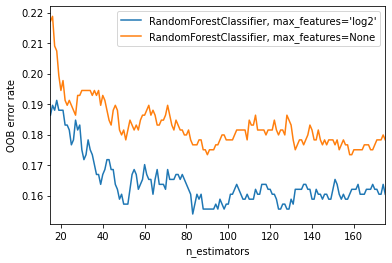

In [117]:
from collections import OrderedDict
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings('ignore')

ensemble_clfs = [
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True, random_state=42)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, random_state=42)) ]


error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()